### Importing the libraries

In [1]:
!pip install category_encoders
!pip install pycaret
!pip install optuna

In [46]:
# For data manipulation and processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import pickle

# For data processing
from sklearn.preprocessing import RobustScaler
import category_encoders as ce
from sklearn.model_selection import train_test_split

# For creating pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer

# For model training
from sklearn.linear_model import LinearRegression
from pycaret.regression import (
    setup,
    compare_models,
    evaluate_model,
    predict_model,
    save_model,
    load_model,
    models,
)
from sklearn.metrics import r2_score

# For hyper-parameter optimizatin
import optuna

print("Everything imported succesfully !")

Everything imported succesfully !


## Loading the data from csv file

- State FIPS: The Federal Information Processing Standards (FIPS) code for the state where the data pertains. It provides a unique identifier for each state in the dataset.
- Area Name: The name of the area or state specified by the State FIPS code. It represents the geographical region to which the occupational employment growth projections apply.
- Occupation Code: The code representing a specific occupation. It follows a standardized classification system (such as the Standard Occupational Classification - SOC) and uniquely identifies each occupation in the dataset.
- Occupation Name: The name or title of the occupation. It provides a descriptive label for each occupation specified by the Occupation Code.
- Base Year: The year for which the initial employment data is recorded or considered as the baseline. It represents the starting point for analyzing employment growth.
- Base: The number of employed individuals in the specified occupation during the Base Year. It represents the initial employment count for each occupation.
- Projected Year: The year for which the employment growth projection is made. It represents the future time point at which the projected employment numbers apply.
- Projection: The projected number of employed individuals in the specified occupation during the Projected Year. It represents the estimated employment count after the projected growth or change.
- Change: The absolute change in employment count between the Base Year and the Projected Year. It indicates the difference in the number of employed individuals for a specific occupation over the projection period.
- Percent Change: The percentage change in employment count between the Base Year and the Projected Year. It represents the relative growth or decline in employment for a particular occupation.
- Average Annual Openings: The average number of annual job openings expected for the specified occupation. It provides an estimate of the employment opportunities available each year due to factors like growth and replacement needs.d replacement needs.

In [3]:
# Let's load the data and explore it
df = pd.read_csv("dataset.csv")

### Exploratory data analysis ( Part 1 )s.

In [4]:
# Let's check the shape of the dataset
print("Shape of the dataframe : ", df.shape)

Shape of the dataframe :  (34982, 11)


In [5]:
# Let's check any 4 random rows from the dataset
df.sample(4)

,State FIPS,Area Name,Occupation Code,Occupation Name,Base Year,Base,Projected Year,Projection,Change,Percent Change,Average Annual Openings
31493,51,Virginia,47-3016,Helpers--Roofers,2014,510,2024,580,70,14.3,10
31093,51,Virginia,17-3026,Industrial Engineering Technicians,2014,1050,2024,1060,10,0.6,30
12702,22,Louisiana,29-1067,Surgeons,2014,590,2024,630,40,6.8,20
34407,72,Puerto Rico,13-2099,"Financial Specialists, All Other",2014,840,2024,800,-40,-5.2,10


In [6]:
# Let's get some more basic infomraiton about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34982 entries, 0 to 34981
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   State FIPS               34982 non-null  int64  
 1   Area Name                34982 non-null  object 
 2   Occupation Code          34982 non-null  object 
 3   Occupation Name          34982 non-null  object 
 4   Base Year                34982 non-null  int64  
 5   Base                     34982 non-null  int64  
 6   Projected Year           34982 non-null  int64  
 7   Projection               34982 non-null  int64  
 8   Change                   34982 non-null  int64  
 9   Percent Change           34982 non-null  float64
 10  Average Annual Openings  34982 non-null  int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 2.9+ MB


In [7]:
int_cols = df.select_dtypes(include=np.int64)
float_cols = df.select_dtypes(include=np.float64)

# Changing the datatype from int43 or float64 to int32 or float32
df[int_cols.columns] = df[int_cols.columns].astype(np.int32)
df[float_cols.columns] = df[float_cols.columns].astype(np.float32)

- Before memory usage : 2.9mb
- After memory usage : 1.9mb

In [8]:
# Checking if there are any duplicated values
print("Duplicate values : ", df.duplicated().sum())

Duplicate values :  0


State FIPS                 0.0
Area Name                  0.0
Occupation Code            0.0
Occupation Name            0.0
Base Year                  0.0
Base                       0.0
Projected Year             0.0
Projection                 0.0
Change                     0.0
Percent Change             0.0
Average Annual Openings    0.0
dtype: float64


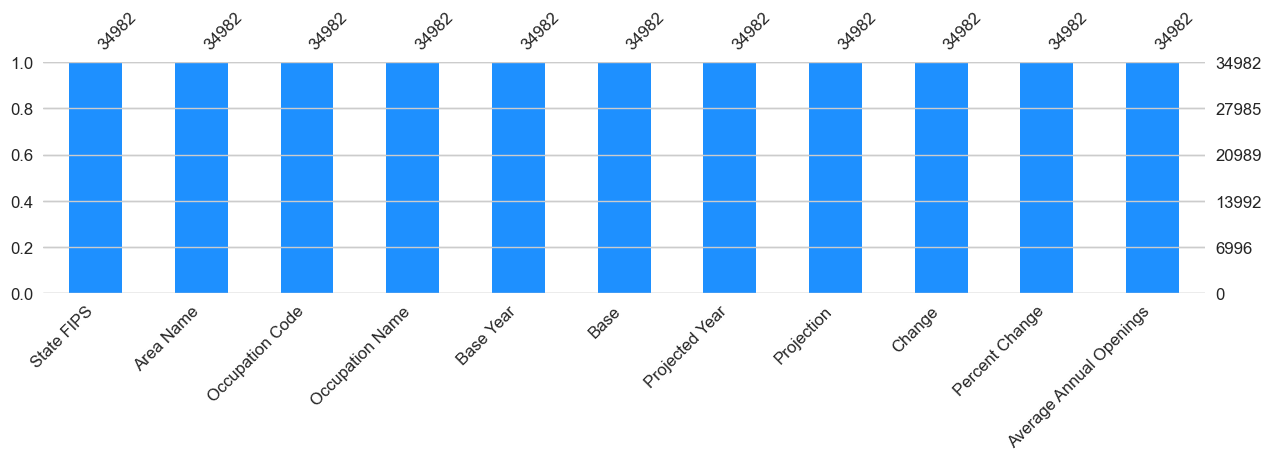

In [9]:
# Percentage of missing values
print(df.isnull().mean() * 100)

# Visualize missing values using a bar chart
msno.bar(df, figsize=(15, 3), color="dodgerblue", sort="ascending", fontsize=12)
plt.show()

In [10]:
# Removing all the rows from dataframe which are summary every area name
df.drop(df[df["Occupation Name"] == "Total, All Occupations"].index, inplace=True)

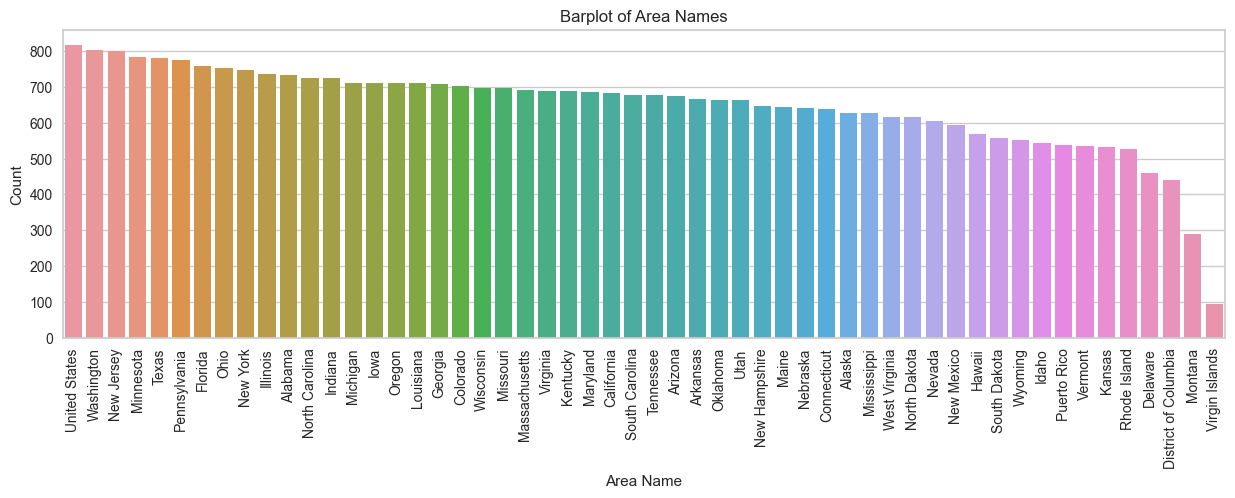

In [11]:
plt.figure(figsize=(15, 4))

# Plotting a bar plot to see data distribution across area names
ax = sns.barplot(
    y=df["Area Name"].value_counts().values, x=df["Area Name"].value_counts().index
)

# Rotate the x-axis labels vertically
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.xlabel("Area Name")
plt.ylabel("Count")
plt.title("Barplot of Area Names")
plt.show()

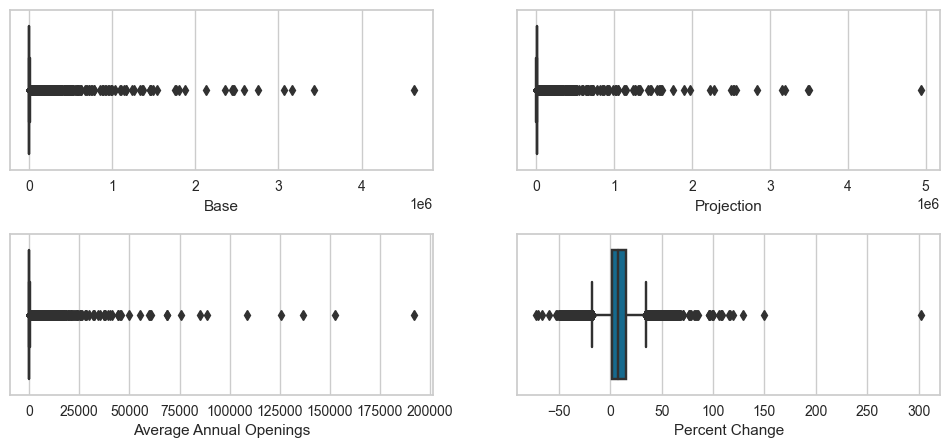

In [12]:
# Let's see if there are any outliers
fig, ax = plt.subplots(2, 2, figsize=(12, 5))

sns.boxplot(x=df["Base"], ax=ax[0][0])
sns.boxplot(x=df["Projection"], ax=ax[0][1])
sns.boxplot(x=df["Average Annual Openings"], ax=ax[1][0])
sns.boxplot(x=df["Percent Change"], ax=ax[1][1])

plt.subplots_adjust(hspace = 0.4,wspace = 0.2)
plt.show()

<Axes: >

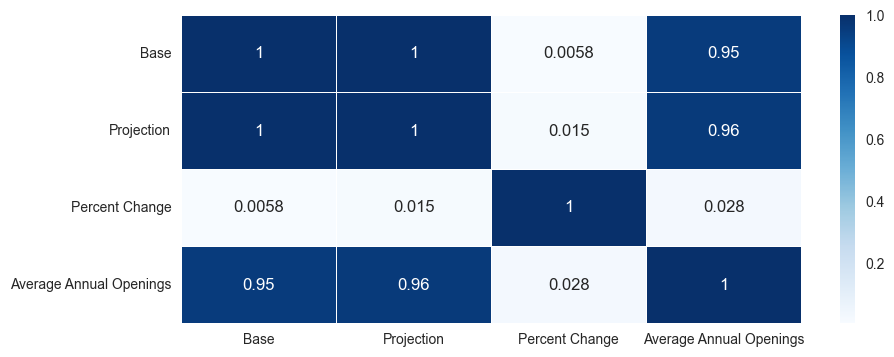

In [13]:
# Let's see the correlation
plt.figure(figsize=(10, 4))

num_df = df[
    ["Base", "Projection", "Percent Change", "Average Annual Openings"]
].copy()
sns.heatmap(data=num_df.corr(), annot=True, linewidths=0.5, cmap="Blues")

In [14]:
print("Total unique occupations are :", len(df["Occupation Name"].unique()))

Total unique occupations are : 819


# Data processing

In this phase we only need to do the following things

- Drop unecessary columns
- Train test and validation split
- Encode the categorical data
- Scale the feature values

In [15]:
# Removing the columns from the dataset
df.drop(
    ["State FIPS", "Occupation Code", "Projected Year", "Base Year","Change"],
    axis=1,
    inplace=True,
)

For the data processing we will create a pipeline but for now let's create a copy of the dataframe and on that copy we will explore all different kind of things and finally we will implemented best techniques on our actual dataset.

In [16]:
# Creating a copy of the dataframe
temp_df = df.copy()
temp_df.reset_index(inplace=True, drop=True)

### Dealing with outliers
From boxplot we got that there are alot of outliers in Base, projection , Average annual openings and percentage change, so instead of removing or capping the outliers we will transform our data using YEO-Johnson transformation.

In [17]:
# Intializing power transformer
pt = PowerTransformer()

cols = ['Base','Projection','Percent Change','Average Annual Openings']
for col in cols:
    temp_df[col] = pd.Series(pt.fit_transform(temp_df[col].values.reshape(-1, 1)).reshape(-1))

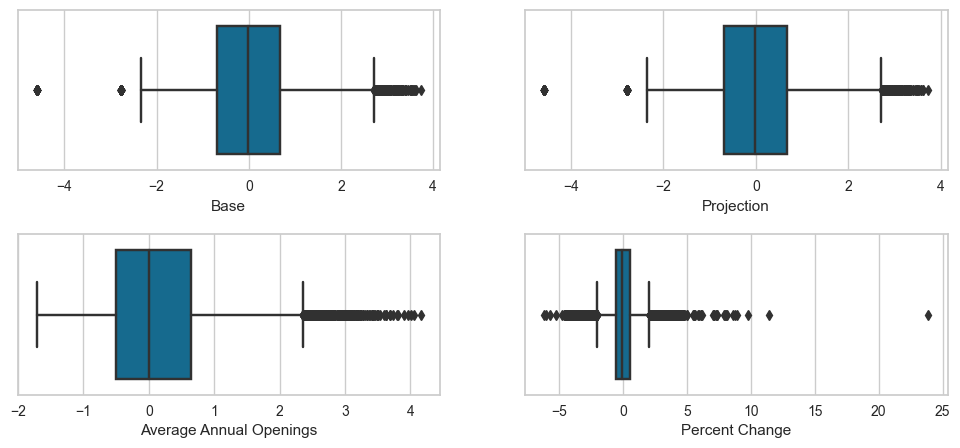

In [18]:
# Let's see if there are any outliers
fig, ax = plt.subplots(2, 2, figsize=(12, 5))

sns.boxplot(x=temp_df["Base"], ax=ax[0][0])
sns.boxplot(x=temp_df["Projection"], ax=ax[0][1])
sns.boxplot(x=temp_df["Average Annual Openings"], ax=ax[1][0])
sns.boxplot(x=temp_df["Percent Change"], ax=ax[1][1])

plt.subplots_adjust(hspace = 0.4,wspace = 0.2)
plt.show()

There are still some outliers but are less in number, so for now let's move on with this and after that we will also compare the model performance by removing the outliers.

In [19]:
df.head(3)

,Area Name,Occupation Name,Base,Projection,Percent Change,Average Annual Openings
1,United States,Chief Executives,343400,339400,-1.2,5840
2,United States,General and Operations Managers,2124100,2275200,7.1,68880
3,United States,Legislators,58300,57900,-0.7,1290


In [20]:
# Intializing the target encoder class
Te_Area_name = ce.TargetEncoder(
    smoothing=0.2, handle_missing="return_nan", return_df=False
)
Te_Occup_name = ce.TargetEncoder(
    smoothing=0.2, handle_missing="return_nan", return_df=False
)

encoded_area_name = pd.Series(Te_Area_name.fit_transform(temp_df["Area Name"].values.reshape(-1, 1), temp_df['Percent Change']).reshape(-1))
encoded_area_name.reset_index(inplace=True, drop=True)
temp_df["Area Name"] = encoded_area_name

encoded_occupation_name = pd.Series(Te_Occup_name.fit_transform(temp_df["Occupation Name"].values.reshape(-1, 1), temp_df['Percent Change']).reshape(-1))
encoded_occupation_name.reset_index(inplace=True, drop=True)
temp_df["Occupation Name"] = encoded_occupation_name

In [22]:
# Let's now do feature scaling (Since our data have outliers so we will use Robust scaling as feature scaling technique)
scaler = RobustScaler()

scaled_data = scaler.fit_transform(temp_df[["Area Name", "Base", "Projection", "Percent Change","Average Annual Openings"]])

scaled_data = pd.DataFrame(
    scaled_data,
    columns=["Area Name", "Base", "Projection", "Change", "Average Annual Openings"],
)
scaled_data.head(5)

,Area Name,Base,Projection,Change,Average Annual Openings
0,-0.306644,2.052887,2.017435,-0.695090,2.216103
1,-0.306644,2.558075,2.549425,-0.061524,3.224358
2,-0.306644,1.509094,1.471608,-0.657421,1.588200
3,-0.306644,1.301963,1.280786,-0.245806,1.536445
4,-0.306644,1.884109,1.877938,0.115464,2.255201


### Train, test and validation split

In [37]:
# Seperating the data into train and test datasets
X = df.drop(["Percent Change"], axis=1)
y = df["Percent Change"]

# Let's do the train test and validation split 85:15 and then 85:15
X_train_Val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=1
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_Val, y_train_val, test_size=0.1765, random_state=1)


# Complete dataset = 34982
print("Train data : ", X_train.shape)
print("Test data : ", X_val.shape)
print("Val data : ", X_test.shape)

Train data :  (24448, 5)
Test data :  (5240, 5)
Val data :  (5240, 5)


In [38]:
Yeo_john_trans = ColumnTransformer(transformers = [
    ("Yeo_Johnson_Transformation",PowerTransformer(),[2,3,4])
],remainder='passthrough')

target_encode_transformer = ColumnTransformer(transformers=[
        ("Target_Encoding",ce.TargetEncoder(smoothing=0.2, handle_missing="return_nan", return_df=False),[3,4])
    ],remainder="passthrough")

scaling_transformer = ColumnTransformer(
    transformers=[("Robust_scaler", RobustScaler(), [2,3,4])],
    remainder="passthrough",
)

pipe = Pipeline(
    steps=[
        ("Yeo-John",Yeo_john_trans),
        ("Target_Encoder", target_encode_transformer),
        ("Robust_Scaling", scaling_transformer)
    ]
)

In [39]:
# Process the training data and testing data
X_train = pipe.fit_transform(X_train, y_train)
X_test = pipe.transform(X_test)

### Comparision of various regression models

In [40]:
y_train = np.array(y_train.values)
y_test = np.array(y_test.values)

In [41]:
pycaret_setup = setup(data=X_train, target=y_train, preprocess=False)

,Description,Value
0,Session id,3194
1,Target,target
2,Target type,Regression
3,Original data shape,"(24448, 6)"
4,Transformed data shape,"(24448, 6)"
5,Transformed train set shape,"(17113, 6)"
6,Transformed test set shape,"(7335, 6)"
7,Categorical features,5


In [42]:
# list of all the regression models
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


By creating embeddings for occupation we were getting these results
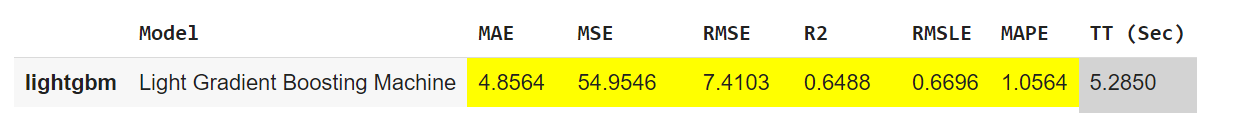

By doing target encoding but without transformation
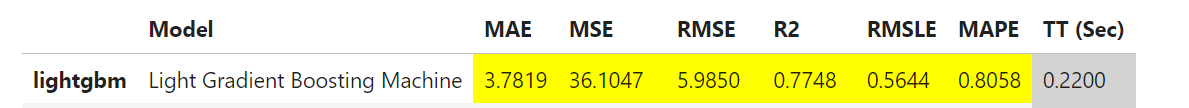

In [43]:
best_model = compare_models(fold=4, cross_validation=True)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,2.2152,17.4981,4.1237,0.8866,0.3997,0.4615,2.1275
lar,Least Angle Regression,2.2152,17.4981,4.1237,0.8866,0.3997,0.4615,0.1325
br,Bayesian Ridge,2.2154,17.4982,4.1238,0.8866,0.3998,0.4616,0.1475
ridge,Ridge Regression,2.4108,17.7663,4.1823,0.8847,0.4206,0.5175,1.2800
huber,Huber Regressor,1.9392,20.2608,4.4035,0.8689,0.3896,0.3386,0.1975
par,Passive Aggressive Regressor,3.4504,30.0988,5.2561,0.8051,0.4935,0.5782,0.1600
gbr,Gradient Boosting Regressor,4.4417,45.6660,6.7554,0.7026,0.6368,0.9826,0.6925
rf,Random Forest Regressor,4.5787,48.6057,6.9694,0.6835,0.6515,1.0132,1.0975
et,Extra Trees Regressor,4.7823,52.2433,7.2251,0.6598,0.6658,1.0468,0.7675
lightgbm,Light Gradient Boosting Machine,4.9194,57.1742,7.5585,0.6277,0.6752,1.0935,0.3800


In [44]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Hyper_Parameter optimization using Optuna

In [47]:
def objective(trial):
  """Objective function for Optuna."""
  copy_X = trial.suggest_categorical("copy_X", [True, False])
  fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
  n_jobs = trial.suggest_int("n_jobs", -1, 16)
  positive = trial.suggest_categorical("positive", [True, False])

  model = LinearRegression(copy_X=copy_X, fit_intercept=fit_intercept, n_jobs=n_jobs, positive=positive)

  score = model.fit(X_train, y_train).score(X_test, y_test)
  return -1.0 * score  # Negative sign to score

study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2023-07-14 15:54:45,164] A new study created in memory with name: no-name-9b043c75-20c3-40bc-9ca3-59efcdef726c
[I 2023-07-14 15:54:45,190] Trial 0 finished with value: -0.8993384123002892 and parameters: {'copy_X': True, 'fit_intercept': False, 'n_jobs': 13, 'positive': False}. Best is trial 0 with value: -0.8993384123002892.
[I 2023-07-14 15:54:45,218] Trial 1 finished with value: -0.9095121651143312 and parameters: {'copy_X': False, 'fit_intercept': True, 'n_jobs': 9, 'positive': False}. Best is trial 1 with value: -0.9095121651143312.
[I 2023-07-14 15:54:45,253] Trial 2 finished with value: -0.9095121651143312 and parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': 2, 'positive': False}. Best is trial 1 with value: -0.9095121651143312.
[I 2023-07-14 15:54:45,284] Trial 3 finished with value: -0.6240071422873374 and parameters: {'copy_X': False, 'fit_intercept': True, 'n_jobs': 2, 'positive': True}. Best is trial 1 with value: -0.9095121651143312.
[I 2023-07-14 15:54:45,

In [ ]:
[I 2023-07-14 15:54:45,218] Trial 1 finished with value: -0.9095121651143312 and 
    parameters: {'copy_X': False, 'fit_intercept': True, 'n_jobs': 9, 'positive': False}. 
Best is trial 1 with value: -0.9095121651143312.

### Model training and evaluation

In [48]:
# Instantiate linear regression model
model = LinearRegression(copy_X=False, fit_intercept=True, n_jobs=9, positive=False)

In [51]:
# Training the model
model.fit(X_train,y_train)

# Making predictions
y_pred = model.predict(X_test)
print("R2 Score of model : ",r2_score(y_test,y_pred))

R2 Score of model :  0.9095121651143312


In [52]:
# Save the model to a file using pickle
with open("model_file.pkl", "wb") as f:
    pickle.dump(model, f)